Took Refrences from:

https://keras.io/guides/keras_cv/classification_with_keras_cv/

https://keras.io/api/keras_cv/models/tasks/image_classifier/#imageclassifier-class

## Inference with a pre-trained classifier:

### mobilenet_v3_large_imagenet_classifier

In [ ]:
!pip install -q --upgrade keras-cv
!pip install -q --upgrade keras  # Upgrade to Keras 3.

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import json
import math
import numpy as np

import keras
from keras import losses
from keras import ops
from keras import optimizers
from keras.optimizers import schedules
from keras import metrics

import keras_cv

# Import tensorflow for `tf.data` and its preprocessing functions
import tensorflow as tf
import tensorflow_datasets as tfds

retriving the pretrained classifier

In [ ]:
classifier = keras_cv.models.ImageClassifier.from_preset(
    "mobilenet_v3_large_imagenet_classifier"
)

31645/31645 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step


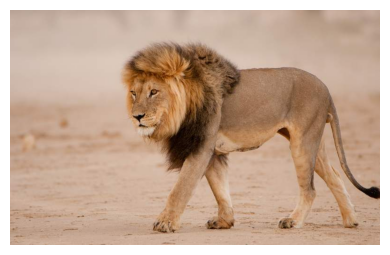

In [ ]:
#The image we're going to classify
filepath = keras.utils.get_file(origin="https://www.krugerpark.co.za/images/black-maned-lion-shem-compion-786x500.jpg")
image = keras.utils.load_img(filepath)
image = np.array(image)
keras_cv.visualization.plot_image_gallery(
    np.array([image]), rows=1, cols=1, value_range=(0, 255), show=True, scale=4
)

In [ ]:
predictions = classifier.predict(np.expand_dims(image, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [ ]:
top_classes = predictions[0].argsort(axis=-1)

In [ ]:
classes = keras.utils.get_file(
    origin="https://gist.githubusercontent.com/LukeWood/62eebcd5c5c4a4d0e0b7845780f76d55/raw/fde63e5e4c09e2fa0a3436680f436bdcb8325aac/ImagenetClassnames.json"
)
with open(classes, "rb") as f:
    classes = json.load(f)

In [ ]:
top_prediction = [classes[str(i)] for i in top_classes[-1:]]
print("Top three classes are:", top_prediction)

Top three classes are: ['lion, king of beasts, Panthera leo']


The pretrained classifier detected the Lion perfectly.

## Fine-tuning a pretrained backbone:

### Detecting if a cell is infected by Malaria or not.

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


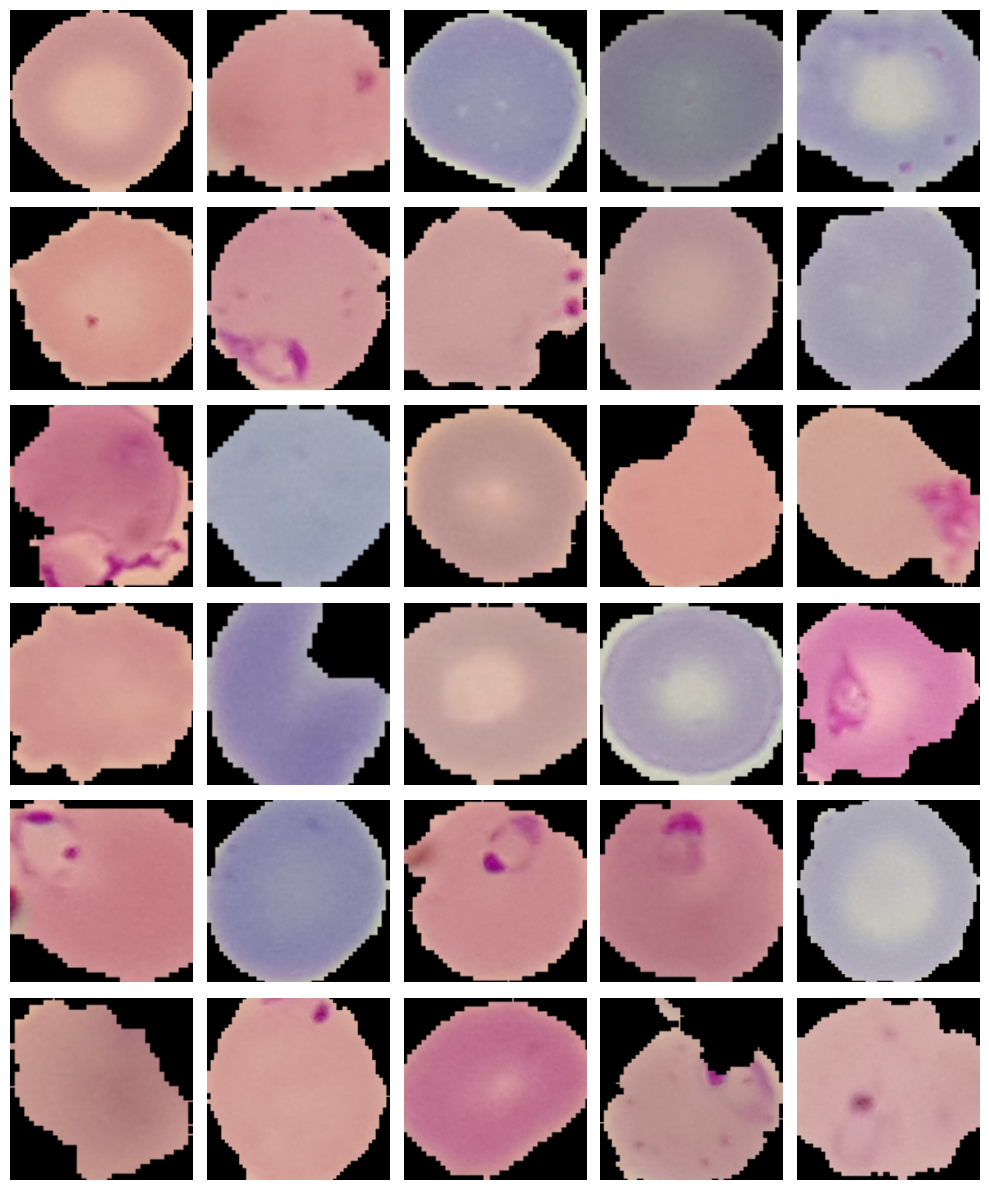

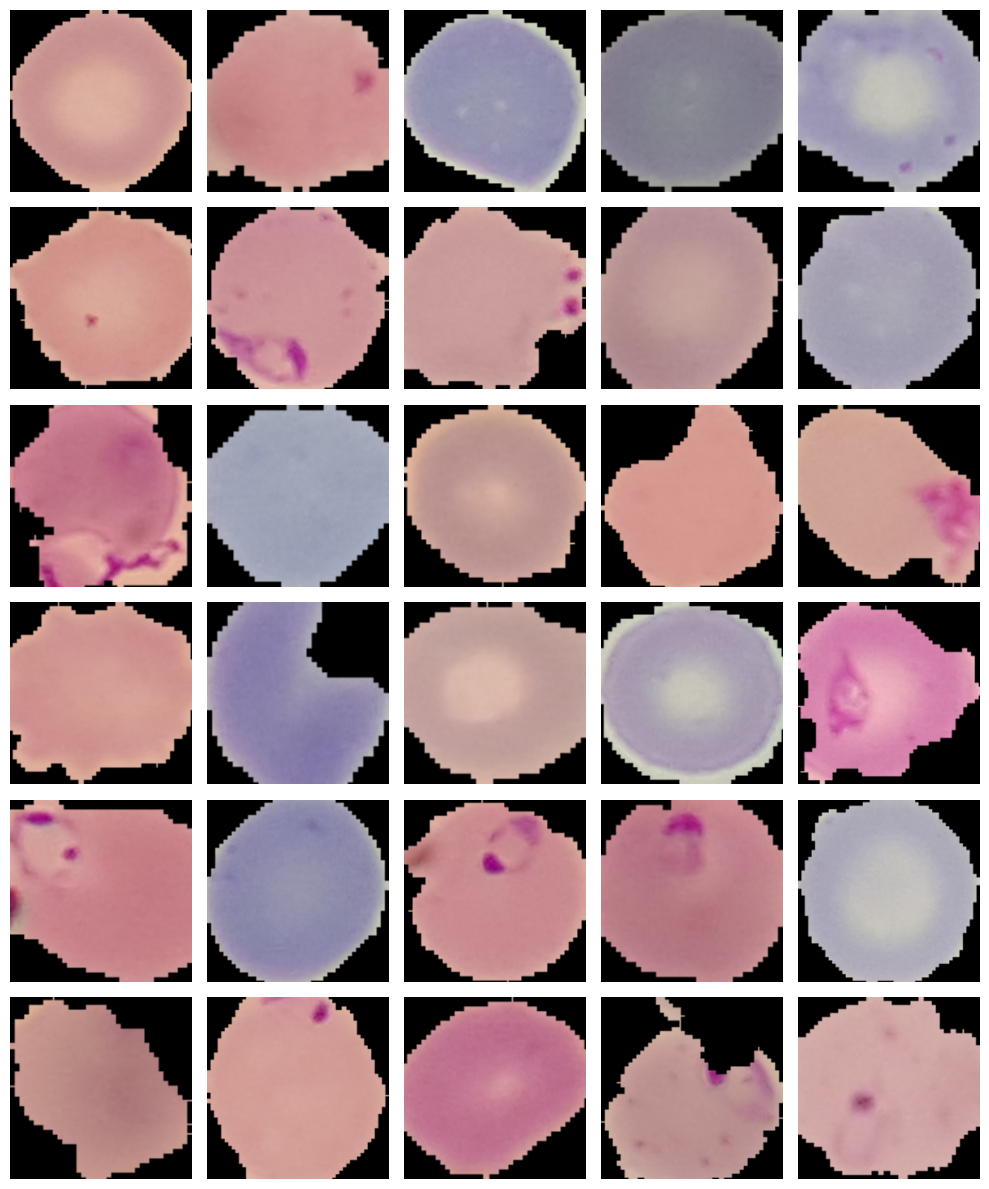

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
tfds.disable_progress_bar()

#retriving he malaria data
data, dataset_info = tfds.load("malaria", with_info=True, as_supervised=True)
train_steps_per_epoch = dataset_info.splits["train"].num_examples // BATCH_SIZE
train_dataset = data["train"]

num_classes = dataset_info.features["label"].num_classes

resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)


def preprocess_inputs(image, label):
    image = tf.cast(image, tf.float32)
    # Staticly resize images as we only iterate the dataset once.
    return resizing(image), tf.one_hot(label, num_classes)


# Shuffle the dataset to increase diversity of batches.
# 10*BATCH_SIZE follows the assumption that bigger machines can handle bigger
# shuffle buffers.
train_dataset = train_dataset.shuffle(
    10 * BATCH_SIZE, reshuffle_each_iteration=True
).map(preprocess_inputs, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

images = next(iter(train_dataset.take(1)))[0]
keras_cv.visualization.plot_image_gallery(images, value_range=(0, 255))

In [ ]:
model = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_b0_imagenet", num_classes=2
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

100%|██████████| 1.79k/1.79k [00:00<00:00, 1.12MB/s]
100%|██████████| 23.1M/23.1M [00:02<00:00, 8.29MB/s]


In [ ]:
model.fit(train_dataset)

862/862 ━━━━━━━━━━━━━━━━━━━━ 158s 145ms/step - accuracy: 0.8043 - loss: 0.4626


In [ ]:
classes = {1: "uninfected", 0: "parasitized"}

In [ ]:
for sample_images, sample_labels in train_dataset.take(1):
    # Select the first 5 images and labels from this batch
    sample_images = sample_images[:5]
    sample_labels = sample_labels[:5]
    break  # We only need the first batch, so break the loop

In [ ]:
sample_predictions = model.predict(sample_images)
predicted_classes = sample_predictions.argmax(axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


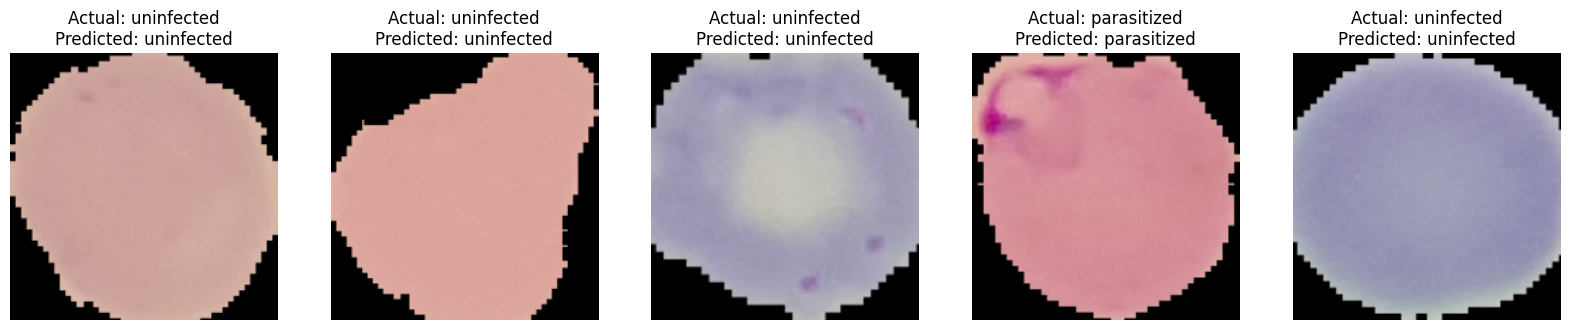

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert one-hot encoded labels back to class indices for comparison
actual_labels = np.argmax(sample_labels, axis=1)

def plot_sample_predictions(images, actual, predictions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Actual: {classes[actual[i]]}\nPredicted: {classes[predictions[i]]}")
        plt.axis("off")
    plt.show()

plot_sample_predictions(sample_images, actual_labels, predicted_classes)

## Training a image classifier from scratch

In [ ]:
NUM_CLASSES = 10
# Change epochs to 100~ to fully train.
EPOCHS = 100
IMAGE_SIZE = (28, 28)
BATCH_SIZE = 32


# def package_inputs(image, label):
#     return {"images": image, "labels": tf.one_hot(label, NUM_CLASSES)}


train_ds, eval_ds = tfds.load(
    "fashion_mnist", split=["train", "test"], as_supervised="true"
)
# train_ds = train_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)
# eval_ds = eval_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)

# train_ds = train_ds.shuffle(BATCH_SIZE * 16)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteWY8QLC/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteWY8QLC/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Preprocess your dataset (resize images to a fixed size, normalize pixel values, etc.)
def preprocess_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0  # Normalize pixel values
    return image, tf.one_hot(label, NUM_CLASSES)

train_ds = train_ds.map(preprocess_image).batch(BATCH_SIZE).shuffle(buffer_size=1000)
eval_ds = eval_ds.map(preprocess_image).batch(BATCH_SIZE)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Model architecture for grayscale image classification
def create_model(input_shape, num_classes):
    model = models.Sequential([
        # Input layer: Convolutional layer
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        # Convolutional layer
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Convolutional layer
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),

        # Fully connected layers
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Define input shape and number of classes
input_shape = (28, 28, 1)  # Assuming input images are 28x28 grayscale
num_classes = 10  # Number of classes in Fashion MNIST dataset

# Create the model
model = create_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(train_ds, epochs=EPOCHS, validation_data=eval_ds)

Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.7447 - loss: 0.6988 - val_accuracy: 0.8483 - val_loss: 0.4018
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8787 - loss: 0.3322 - val_accuracy: 0.8850 - val_loss: 0.3081
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8968 - loss: 0.2809 - val_accuracy: 0.8965 - val_loss: 0.2864
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9073 - loss: 0.2471 - val_accuracy: 0.9016 - val_loss: 0.2642
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9178 - loss: 0.2214 - val_accuracy: 0.9031 - val_loss: 0.2641
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9270 - loss: 0.1962 - val_accuracy: 0.9061 - val_loss: 0.2634
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9351 - loss: 0.1772 - val_accuracy: 0.9079 - val_loss: 0.2686
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9407 - loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


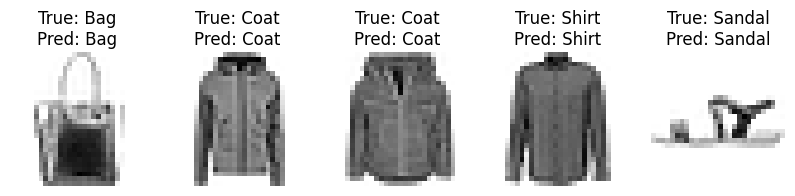

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Function to get N random samples from a dataset
def get_random_samples(dataset, n=5):
    # Shuffle the dataset
    shuffled_ds = dataset.shuffle(1000)
    # Take N samples
    samples = shuffled_ds.take(n)
    return samples

# Function to plot images, true labels, and model predictions
def plot_images_with_predictions(samples, model, class_names):
    plt.figure(figsize=(10, 2 * n))
    for i, (image, label) in enumerate(samples):
        ax = plt.subplot(n, 1, i + 1)
        plt.imshow(image.numpy().squeeze(), cmap=plt.cm.binary)

        true_index = np.argmax(label)
        pred = model.predict(tf.expand_dims(image, 0))
        predicted_index = np.argmax(pred[0])

        true_label = class_names[true_index]
        predicted_label = class_names[predicted_index]

        plt.title(f"True Label: {true_label}, Predicted Label: {predicted_label}")
        plt.axis("off")
    plt.show()

# Assuming you have the class names stored in a list
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Get 5 random samples from the test dataset
random_samples = get_random_samples(eval_ds.unbatch(), 5)

# Convert the samples to a batch for prediction
batch_images, batch_labels = zip(*[(image.numpy(), label.numpy()) for image, label in random_samples])
batch_images = np.array(batch_images)
batch_labels = np.array(batch_labels)

# Predict the labels for the batch
predictions = model.predict(batch_images)

# Plot the images with true and predicted labels
plt.figure(figsize=(10, 10))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(batch_images[i].squeeze(), cmap=plt.cm.binary)
    true_label = class_names[np.argmax(batch_labels[i])]
    predicted_label = class_names[np.argmax(predictions[i])]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis("off")
plt.show()